In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FunctionTransformer
from scipy import stats

def evaluate(grid, X_test, y_test):

    # Show the best model
    print('Best model: ', grid.best_estimator_)

    # Show the best parameters
    print('Best R2 grid: ', grid.best_score_)

    # Show the best R2 score
    print('Best R2 estimator: ', grid.best_estimator_.score(X_test, y_test))

    # Show the best RMSE
    y_pred = grid.best_estimator_.predict(X_test)
    
    # Inverse to yield
    y_pred = y_pred.flatten() / X_test['a_BAL_SEPA_Feed_PV']
    y_test = y_test / X_test['a_BAL_SEPA_Feed_PV']

    print('Best RMSE estimator: ', np.sqrt(mean_squared_error(y_test, y_pred)))

    # Create a predicted vs true plot
    plt.figure(figsize=(10,10))
    plt.scatter(y_test, y_pred.flatten(), c='crimson')
    # plt.yscale('log')
    # plt.xscale('log')
    p1 = max(max(y_pred.flatten()), max(y_test))
    p2 = min(min(y_pred.flatten()), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()

    plt.figure(figsize=(25,7))
    plt.plot(y_test.values, label='True')
    plt.plot(y_pred.flatten(), label='Predicted')
    plt.legend()
    plt.show()


# Load raw data

In [3]:
stet_dir_path = 'C:/Users/k.chiotis/OneDrive - Titan Cement Company SA/Desktop/STET'
tags = pd.read_csv(stet_dir_path+'/BAL SEP A/tags_bal_sep_a.csv', sep=';')

df_raw = pd.read_csv(stet_dir_path+'/BAL SEP A/2023_05_11/data_bal_sep_a.csv', sep=';', decimal=",")
df_raw['DateInterval'] = pd.to_datetime(df_raw['DateInterval'])

# Remove rows with feed < 100
df_raw = df_raw[df_raw['a_BAL_SEPA_Feed_PV'] > 100]

# The df_raw is a time series data set which data are generated by sensors.
# Whenever, a sensor captures a change the value is recorded in the df_raw otherwise the value is NaN.
# Finally,  we have quality features which are not monitored by sensors and they filled by operators.
quality_features = ['a_BAL_SEPA_Q_C_FI', 'a_BAL_SEPA_Q_C_LOI', 'a_BAL_SEPA_Q_F_FI', 'a_BAL_SEPA_Q_F_LOI', 'a_BAL_SEPA_Q_P_FI', 'a_BAL_SEPA_Q_P_LOI', 'a_BAL_SEPA_Q_PC_LOI', 'a_BAL_SEPA_Q_Y']
df_raw.loc[:, ~df_raw.columns.isin(quality_features)] = df_raw.loc[:, ~df_raw.columns.isin(quality_features)].fillna(method='ffill')

# Remove rows where any quality feature is zero
# df_raw = df_raw[(df_raw[['a_BAL_SEPA_Q_C_LOI', 'a_BAL_SEPA_Q_F_LOI', 'a_BAL_SEPA_Q_P_LOI', 'a_BAL_SEPA_Q_Y']] != 0).all(axis=1)]

# Create a new column for the operation number based on a_BAL_SEPA_Belt_FT. If the previous value is higher than the current value then a new operation starts
# df_raw['operationNo'] = (df_raw['a_BAL_SEPA_Belt_FT'] < df_raw['a_BAL_SEPA_Belt_FT'].shift()).cumsum() + 1

# Calculate the time difference in seconds between the current and the previous row
df_raw['time_diff'] = (df_raw['DateInterval'] - df_raw['DateInterval'].shift()).dt.total_seconds()

# Create a new column for the operation number based on the time difference (> 10000 seconds)
df_raw['operationNo'] = (df_raw['time_diff'] > 10000).cumsum() + 1


# Forward fill a_BAL_SEPA_Q_F_LOI grouped by operationNo
# df_raw['a_BAL_SEPA_Q_F_LOI'] = df_raw.groupby('operationNo')['a_BAL_SEPA_Q_F_LOI'].transform(lambda x: x.fillna(method='ffill'))

# Shift a_BAL_SEPA_Q_F_LOI 1 row down
# df_raw['a_BAL_SEPA_Q_F_LOI'] = df_raw.groupby('operationNo')['a_BAL_SEPA_Q_F_LOI'].shift(1)

# Calaculate a_BAL_A_SEPA_Feed_PV moving average for each operationNo
# df_raw['a_BAL_SEPA_Feed_PV'] = df_raw.groupby('operationNo')['a_BAL_SEPA_Feed_PV'].transform(lambda x: x.rolling(10, 1).mean())

# Calculate again yield
# df_raw['a_BAL_SEPA_Q_Y'] = (df_raw['a_BAL_SEPA_Q_C_LOI'] - df_raw['a_BAL_SEPA_Q_F_LOI']) / (df_raw['a_BAL_SEPA_Q_C_LOI'] - df_raw['a_BAL_SEPA_Q_P_LOI'])

# Calculate product as: product = yield * feed where feed is a_BAL_SEPA_Feed_PV and yield is a_BAL_SEPA_Q_Y
df_raw['product'] = df_raw['a_BAL_SEPA_Q_Y'] * df_raw['a_BAL_SEPA_Feed_PV']

# Calculate carbon as: carbon = feed - product
df_raw['carbon'] = df_raw['a_BAL_SEPA_Feed_PV'] - df_raw['product']

# Calculate good product as: good_product = product * (1 - a_BAL_SEPA_Q_P_LOI)
df_raw['good_product'] = df_raw['product'] * (1 - df_raw['a_BAL_SEPA_Q_P_LOI'])

# Calculate bad product as: bad_product = product * a_BAL_SEPA_Q_P_LOI
df_raw['bad_product'] = df_raw['product'] * df_raw['a_BAL_SEPA_Q_P_LOI']

# Calculate good carbon as: good_carbon = carbon * a_BAL_SEPA_Q_C_LOI
df_raw['good_carbon'] = df_raw['carbon'] * (1 - df_raw['a_BAL_SEPA_Q_C_LOI'])

# Calculate bad carbon as: bad_carbon = carbon * a_BAL_SEPA_Q_C_LOI
df_raw['bad_carbon'] = df_raw['carbon'] * df_raw['a_BAL_SEPA_Q_C_LOI']

# Selected features
features = ['a_BAL_SEPA_A_HV_Neg_mA_PV', 'a_BAL_SEPA_A_HV_Pos_mA_PV', 'a_BAL_SEPA_AmbientTemp', 'a_BAL_SEPA_Belt_Gap', 'a_BAL_SEPA_Belt_Speed_PV', 'a_BAL_SEPA_E1_Torque_PV','a_BAL_SEPA_E2_Torque_PV','a_BAL_SEPA_Feed_PV','a_BAL_SEPA_FeedRH','a_BAL_SEPA_FeedTemp','a_BAL_BOPA_Q_Mineral_Blower_Pressure','a_BAL_BOPA_Q_Mineral_Pump_Current','a_BAL_BOPA_Q_Carbon_Blower_Pressure','a_BAL_BOPA_Q_Carbon_Pump_Current']

# SMA of features
window = 1
for feature in features:
    df_raw[feature] = df_raw.groupby('operationNo')[feature].transform(lambda x: x.rolling(window, 1).mean())



C:\Users\k.chiotis\AppData\Local\Temp\ipykernel_16148\1051405932.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_raw.loc[:, ~df_raw.columns.isin(quality_features)] = df_raw.loc[:, ~df_raw.columns.isin(quality_features)].fillna(method='ffill')


# Find relationships between product and pump/blower pressures

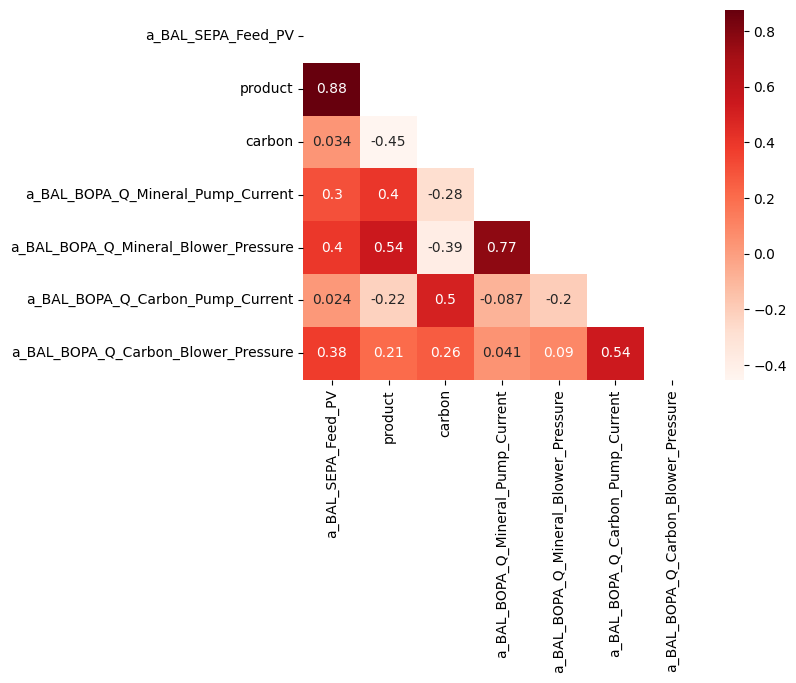

In [3]:
df = df_raw.copy()

# Keep the columns where product yield (a_BAL_SEPA_Q_Y) is not NaN and not 0
df = df_raw[df_raw['a_BAL_SEPA_Q_Y'].notna()]
df = df[df['a_BAL_SEPA_Q_Y'] != 0]

# Keep columns on the following order: a_BAL_SEPA_Feed_PV, product, carbon, a_BAL_SEPA_Q_Y, a_BAL_SEPA_Q_F_LOI, a_BAL_SEPA_Q_P_LOI, a_BAL_SEPA_Q_C_LOI, a_BAL_BOPA_Q_Mineral_Pump_Current, a_BAL_BOPA_Q_Mineral_Blower_Pressure, a_BAL_BOPA_Q_Carbon_Pump_Current, a_BAL_BOPA_Q_Carbon_Blower_Pressure
df = df[['a_BAL_SEPA_Feed_PV', 'product', 'carbon', 'a_BAL_BOPA_Q_Mineral_Pump_Current', 'a_BAL_BOPA_Q_Mineral_Blower_Pressure', 'a_BAL_BOPA_Q_Carbon_Pump_Current', 'a_BAL_BOPA_Q_Carbon_Blower_Pressure']]

# Calculate correlations between features
corr_matrix = df.corr()

# Create a correlation plot with colors with the upper triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds, mask=mask)
plt.show()

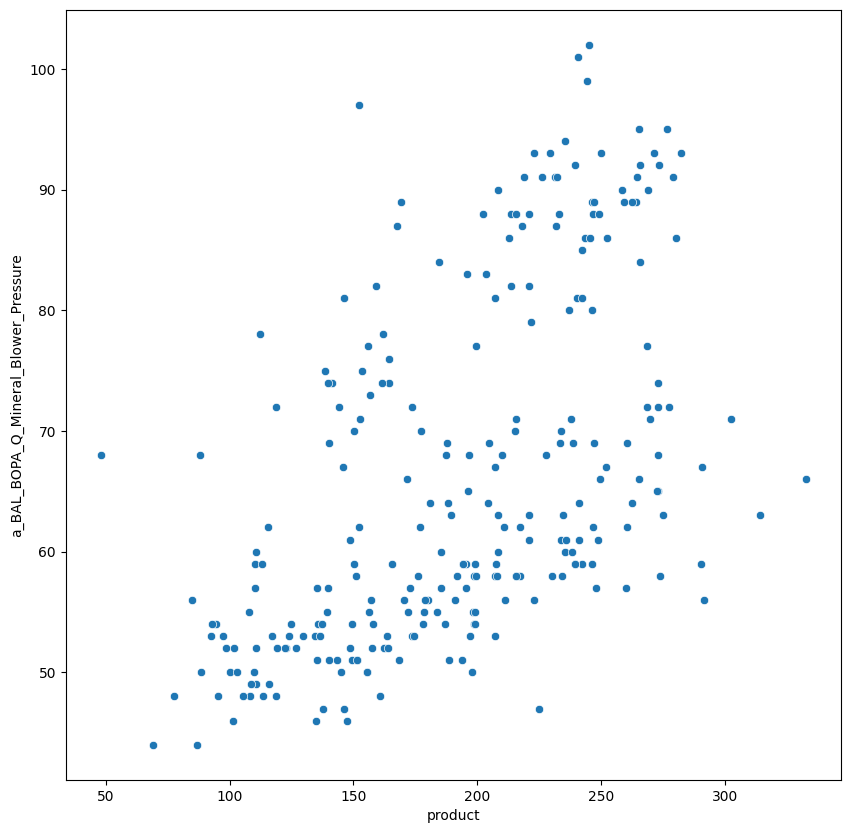

In [4]:
# Create a plot to visualize the relationship between product and a_BAL_BOPA_Q_Mineral_Blower_Pressure
plt.figure(figsize=(10,10))
sns.scatterplot(x='product', y='a_BAL_BOPA_Q_Mineral_Blower_Pressure', data=df)
plt.show()

# Predict Yield

Best model:  PLSRegression(max_iter=100, n_components=4, scale=False)
Best R2 grid:  0.6228197501058347
Best R2 estimator:  0.6446337523462755
Best RMSE estimator:  0.07728636999922571


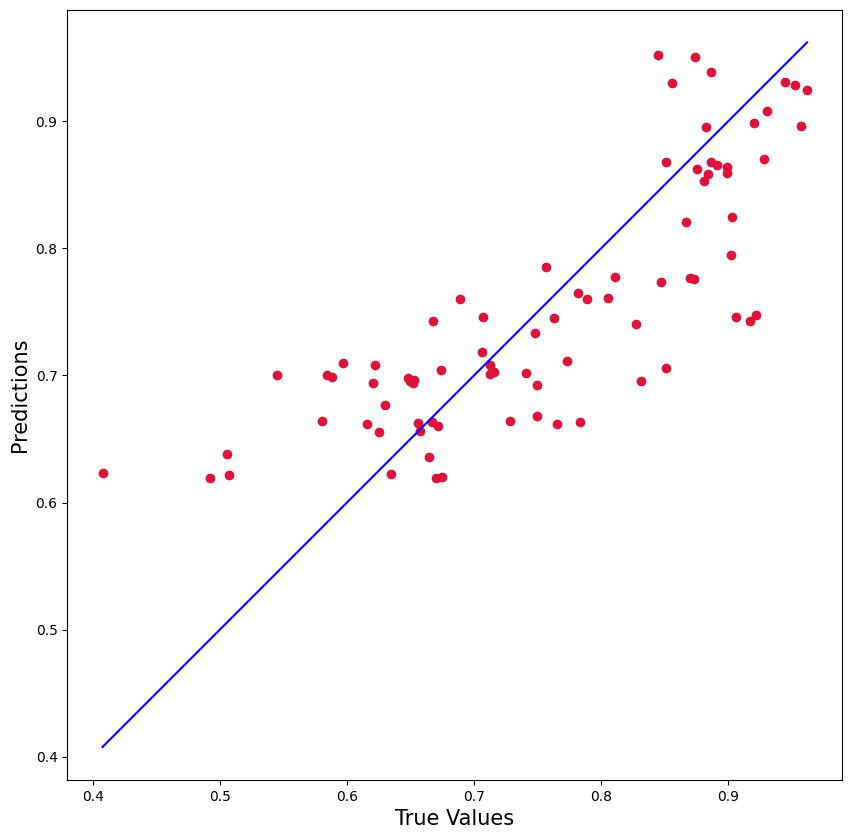

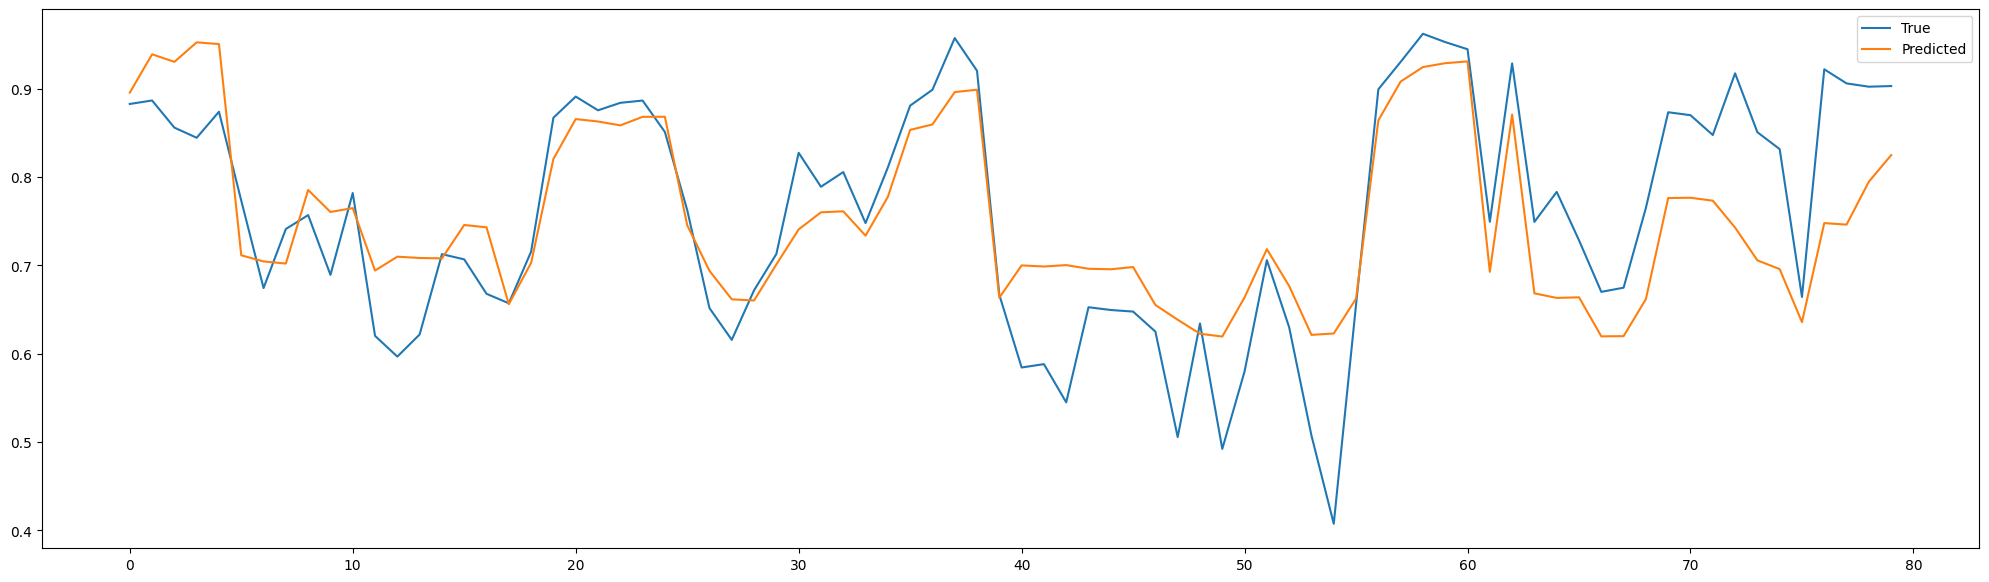

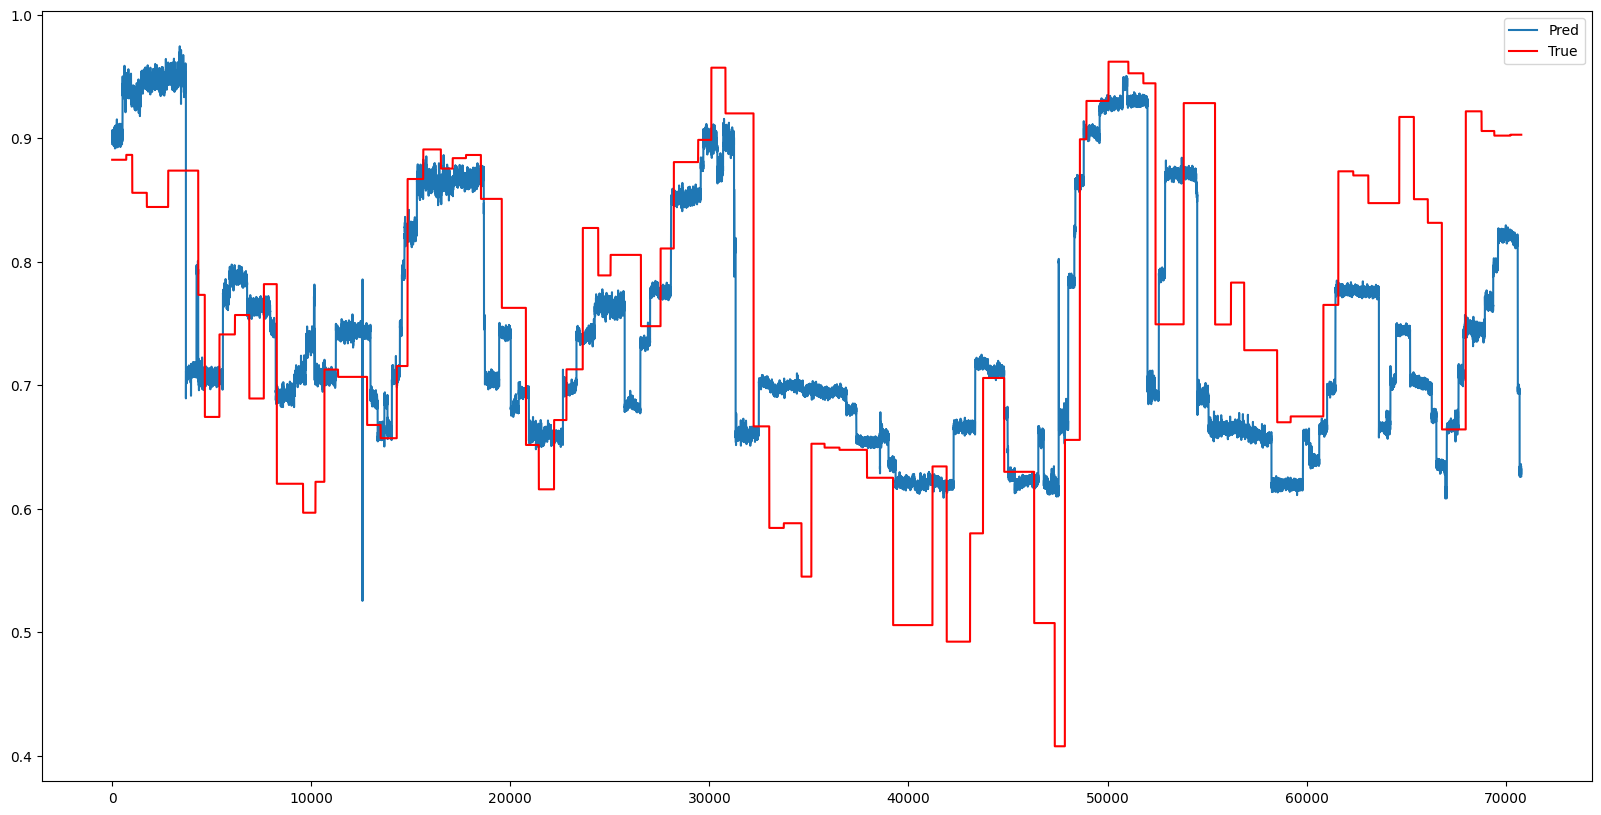

In [20]:
df = df_raw.copy()


df = df[features + ['a_BAL_SEPA_Q_Y']]


df = df[df['a_BAL_SEPA_Q_Y'].notna()]
df = df[df['a_BAL_SEPA_Q_Y'] != 0]

# profile = ProfileReport(df, title="YIELD EDA")
# profile.to_file(f"eda_yield_stet.html")

y = df.a_BAL_SEPA_Q_Y.copy()
X = df.drop('a_BAL_SEPA_Q_Y', axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)
X_train = X[:int(0.7 * len(X))]
X_test = X[int(0.7 * len(X)):]
y_train = y[:int(0.7 * len(y))]
y_test = y[int(0.7 * len(y)):]

# Use GridSearchCV to find the best number of components and other parameters for PLS regression
pls = PLSRegression()
param_grid = {'n_components': [i for i in range(1, X_train.shape[1] + 1)],
                'scale': [True, False],
                'max_iter': [i for i in range(100, 1000, 100)]}
grid = GridSearchCV(pls, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
# grid.fit(X, y)

evaluate(grid, X_test, y_test)

# Get sub df of df_raw where index > 182466
test_df = df_raw[df_raw.index > 182466]
test_df = test_df[features]

# Predict yield for operation 127
y_pred = grid.predict(test_df)

# Attach predicted yield to test_df
test_df['a_BAL_SEPA_Q_Y_pred'] = y_pred

# Join Dateinterval from df_raw to test_df based on index
test_df = test_df.join(df_raw['DateInterval'], how='left')

# Keep dateinterval and a_BAL_SEPA_Q_Y_pred
test_df = test_df[['DateInterval', 'a_BAL_SEPA_Q_Y_pred']]

# Join a_BAL_SEPA_Q_Y from df_raw to test_df based on index
test_df = test_df.join(df_raw['a_BAL_SEPA_Q_Y'], how='left')

# Remove rows where a_BAL_SEPA_Q_Y is zero
test_df = test_df[test_df['a_BAL_SEPA_Q_Y'] != 0]

# Keep rows where a_BAL_SEPA_Q_Y is not null or DateInterval diff is more than 1 minute

# Drop rows where a_BAL_SEPA_Q_Y is null 

test_df = test_df.reset_index(drop=True)

# Plot the time series a_BAL_SEPA_Q_Y_pred and mark the a_BAL_SEPA_Q_Y values when they are not null
plt.figure(figsize=(20, 10))
plt.plot(test_df['a_BAL_SEPA_Q_Y_pred'], label='Pred')
plt.plot(test_df['a_BAL_SEPA_Q_Y'].fillna(method='ffill'), label='True', c='r')
# plt.scatter(test_df.index, test_df['a_BAL_SEPA_Q_Y'], c='r', label='True')
plt.legend()
plt.show()




# Predict Product LOI

Best model:  PLSRegression(max_iter=100, n_components=6)
Best R2 grid:  0.11733850698574433
Best R2 estimator:  0.21956394100836574
Best RMSE estimator:  0.006426210377060453


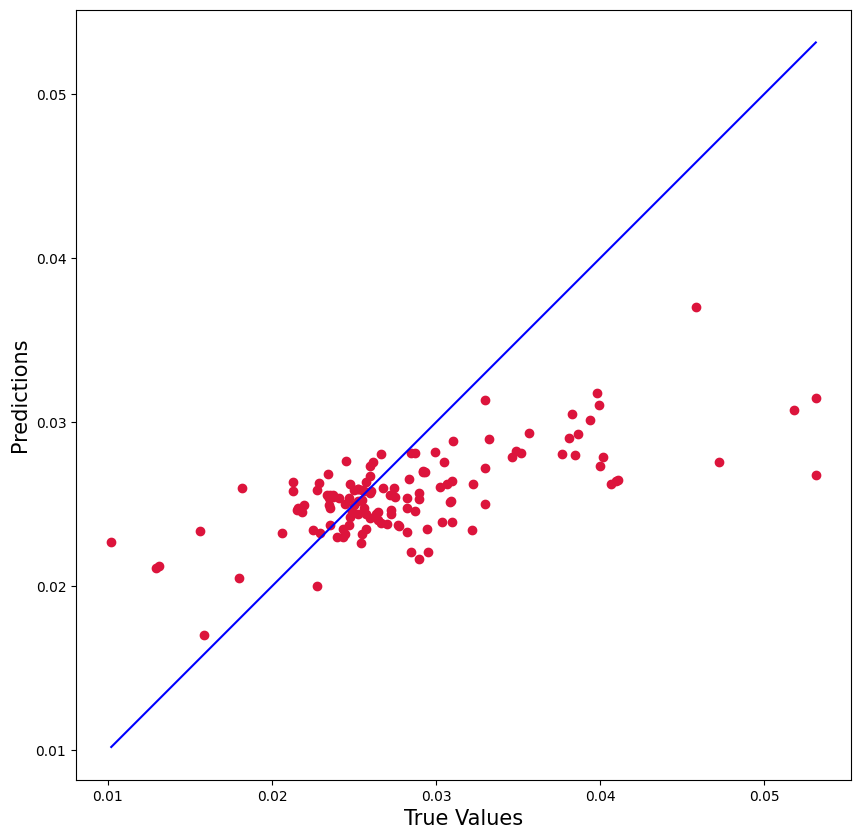

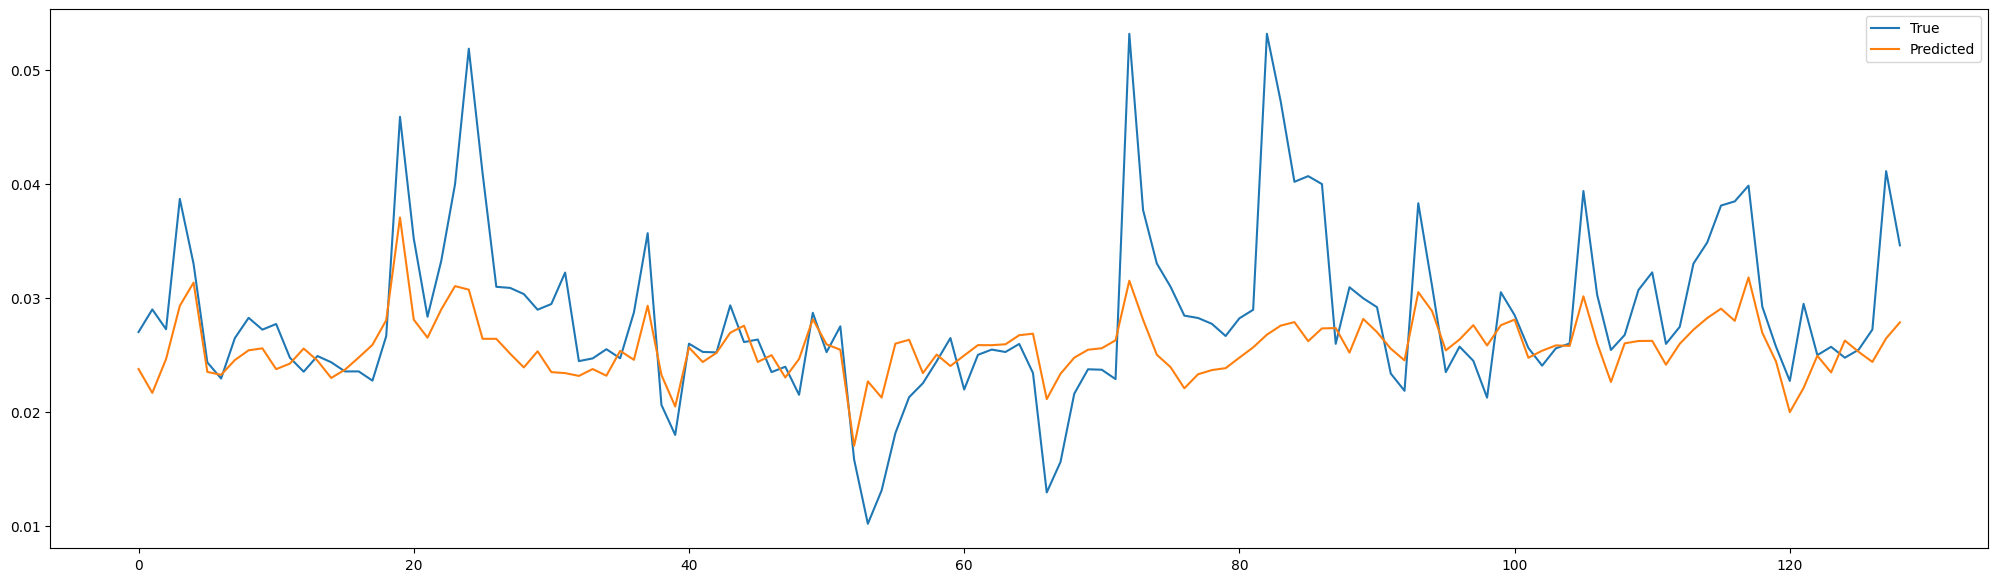

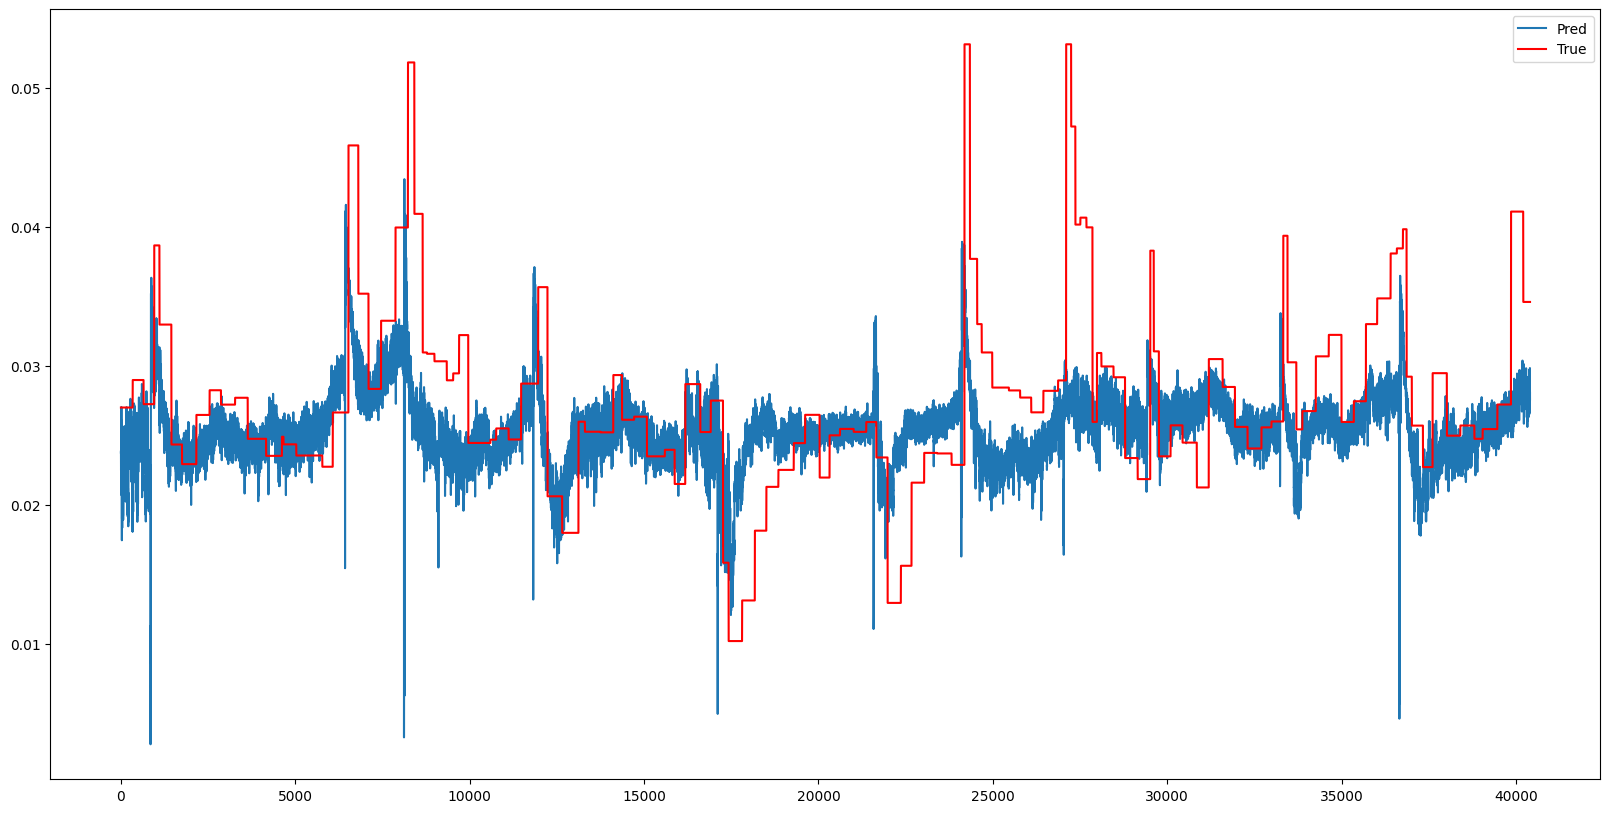

In [21]:
df = df_raw.copy()

df = df[['a_BAL_SEPA_A_HV_Neg_mA_PV', 
         'a_BAL_SEPA_A_HV_Pos_mA_PV', 
         'a_BAL_SEPA_AmbientTemp', 
         'a_BAL_SEPA_Belt_Gap', 
         'a_BAL_SEPA_Belt_Speed_PV', 
         'a_BAL_SEPA_E1_Torque_PV',
         'a_BAL_SEPA_E2_Torque_PV',
         'a_BAL_SEPA_Feed_PV',
         'a_BAL_SEPA_FeedRH',
         'a_BAL_SEPA_FeedTemp',
         'a_BAL_SEPA_M2_Speed_PV',
         'a_BAL_BOPA_Q_Mineral_Blower_Pressure',
         'a_BAL_BOPA_Q_Mineral_Pump_Current',
         'a_BAL_BOPA_Q_Carbon_Blower_Pressure',
         'a_BAL_BOPA_Q_Carbon_Pump_Current',
         'a_BAL_SEPA_Q_P_LOI']]

df = df[df['a_BAL_SEPA_Q_P_LOI'].notna()]
df = df[df['a_BAL_SEPA_Q_P_LOI'] != 0]

# Apply 3 sigma rule to a_BAL_SEPA_Q_P_LOI to remove outliers 
df = df[np.abs(df['a_BAL_SEPA_Q_P_LOI'] - df['a_BAL_SEPA_Q_P_LOI'].mean()) <= (3 * df['a_BAL_SEPA_Q_P_LOI'].std())]

# Appply box cox transformation to skewed a_BAL_SEPA_A_HV_Neg_mA_PV and a_BAL_SEPA_A_HV_Pos_mA_PV
df['a_BAL_SEPA_A_HV_Neg_mA_PV'], lambda_Neg = stats.boxcox(df['a_BAL_SEPA_A_HV_Neg_mA_PV'].to_numpy())
df['a_BAL_SEPA_A_HV_Pos_mA_PV'], lambda_Pos = stats.boxcox(df['a_BAL_SEPA_A_HV_Pos_mA_PV'].to_numpy())

# profile = ProfileReport(df, title="Product LOI EDA")
# profile.to_file(f"eda_p_loi_stet.html")

y = df.a_BAL_SEPA_Q_P_LOI.copy()
X = df.drop('a_BAL_SEPA_Q_P_LOI', axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
X_train = X[:int(0.8 * len(X))]
X_test = X[int(0.8 * len(X)):]
y_train = y[:int(0.8 * len(y))]
y_test = y[int(0.8 * len(y)):]

# Use GridSearchCV to find the best number of components and other parameters for PLS regression
pls = PLSRegression()
param_grid = {'n_components': [i for i in range(1, 16)],
                'scale': [True, False],
                'max_iter': [i for i in range(100, 1000, 100)]}
grid = GridSearchCV(pls, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

evaluate(grid, X_test, y_test)

# Get sub df of df_raw where index > 215108
test_df = df_raw[df_raw.index > 215108]
test_df = test_df[['a_BAL_SEPA_A_HV_Neg_mA_PV',
                    'a_BAL_SEPA_A_HV_Pos_mA_PV',
                    'a_BAL_SEPA_AmbientTemp',
                    'a_BAL_SEPA_Belt_Gap',
                    'a_BAL_SEPA_Belt_Speed_PV',
                    'a_BAL_SEPA_E1_Torque_PV',
                    'a_BAL_SEPA_E2_Torque_PV',
                    'a_BAL_SEPA_Feed_PV',
                    'a_BAL_SEPA_FeedRH',
                    'a_BAL_SEPA_FeedTemp',
                    'a_BAL_SEPA_M2_Speed_PV',
                    'a_BAL_BOPA_Q_Mineral_Blower_Pressure',
                    'a_BAL_BOPA_Q_Mineral_Pump_Current',
                    'a_BAL_BOPA_Q_Carbon_Blower_Pressure',
                    'a_BAL_BOPA_Q_Carbon_Pump_Current',
                ]]

# Use lambdas from box cox transformation to transform a_BAL_SEPA_A_HV_Neg_mA_PV and a_BAL_SEPA_A_HV_Pos_mA_PV
test_df['a_BAL_SEPA_A_HV_Neg_mA_PV'] = stats.boxcox(test_df['a_BAL_SEPA_A_HV_Neg_mA_PV'].to_numpy(), lambda_Neg)
test_df['a_BAL_SEPA_A_HV_Pos_mA_PV'] = stats.boxcox(test_df['a_BAL_SEPA_A_HV_Pos_mA_PV'].to_numpy(), lambda_Pos)

# Predict yield for operation 127
y_pred = grid.predict(test_df)

# Attach predicted yield to test_df
test_df['a_BAL_SEPA_Q_P_LOI_pred'] = y_pred

# Join Dateinterval from df_raw to test_df based on index
test_df = test_df.join(df_raw['DateInterval'], how='left')

# Keep dateinterval and a_BAL_SEPA_Q_Y_pred
test_df = test_df[['DateInterval', 'a_BAL_SEPA_Q_P_LOI_pred']]

# Join a_BAL_SEPA_Q_Y from df_raw to test_df based on index
test_df = test_df.join(df_raw['a_BAL_SEPA_Q_P_LOI'], how='left')

# Remove rows where a_BAL_SEPA_Q_Y is zero
test_df = test_df[test_df['a_BAL_SEPA_Q_P_LOI'] != 0]

# Keep rows where a_BAL_SEPA_Q_Y is not null or DateInterval diff is more than 1 minute

# Drop rows where a_BAL_SEPA_Q_Y is null 

test_df = test_df.reset_index(drop=True)

# Plot the time series a_BAL_SEPA_Q_Y_pred and mark the a_BAL_SEPA_Q_Y values when they are not null
plt.figure(figsize=(20, 10))
plt.plot(test_df['a_BAL_SEPA_Q_P_LOI_pred'], label='Pred')
plt.plot(test_df['a_BAL_SEPA_Q_P_LOI'].fillna(method='ffill'), label='True', c='r')
# plt.scatter(test_df.index, test_df['a_BAL_SEPA_Q_Y'], c='r', label='True')
plt.legend()
plt.show()

# Predict Product

In [18]:
df = df_raw.copy()

df = df[['a_BAL_SEPA_A_HV_Neg_mA_PV', 
         'a_BAL_SEPA_A_HV_Pos_mA_PV', 
         'a_BAL_SEPA_AmbientTemp', 
         'a_BAL_SEPA_Belt_Gap', 
         'a_BAL_SEPA_Belt_Speed_PV', 
         'a_BAL_SEPA_E1_Torque_PV',
         'a_BAL_SEPA_E2_Torque_PV',
         'a_BAL_SEPA_Feed_PV',
         'a_BAL_SEPA_FeedRH',
         'a_BAL_SEPA_FeedTemp',
         'a_BAL_SEPA_M2_Speed_PV',
         'a_BAL_BOPA_Q_Mineral_Blower_Pressure',
         'a_BAL_BOPA_Q_Mineral_Pump_Current',
         'a_BAL_BOPA_Q_Carbon_Blower_Pressure',
         'a_BAL_BOPA_Q_Carbon_Pump_Current',
         'product']]

df = df[df['product'].notna()]
df = df[df['product'] != 0]

# profile = ProfileReport(df, title="Product EDA")
# profile.to_file(f"eda_product_stet.html")

y = df['product'].copy()
X = df.drop('product', axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
# Split the data by getting the first 70 % data as training set and the rest as test set
X_train = X[:int(0.7 * len(X))]
X_test = X[int(0.7 * len(X)):]
y_train = y[:int(0.7 * len(y))]
y_test = y[int(0.7 * len(y)):]

# Use GridSearchCV to find the best number of components and other parameters for PLS regression
pls = PLSRegression()
param_grid = {'n_components': [i for i in range(1, 16)],
                'scale': [True, False],
                'max_iter': [i for i in range(100, 1000, 100)]}
grid = GridSearchCV(pls, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
grid.fit(X_train, y_train)


evaluate(grid, X_test, y_test)

Best model:  PLSRegression(max_iter=100, n_components=5, scale=False)
Best R2 grid:  0.869397443378109
Best R2 estimator:  0.8912267411104058


AttributeError: 'Series' object has no attribute 'flatten'

# Predict Good Product

Best model:  PLSRegression(max_iter=100, n_components=5)
Best R2 grid:  0.9296402608063292
Best R2 estimator:  0.9012218818188823
Best RMSE estimator:  17.812062378268944


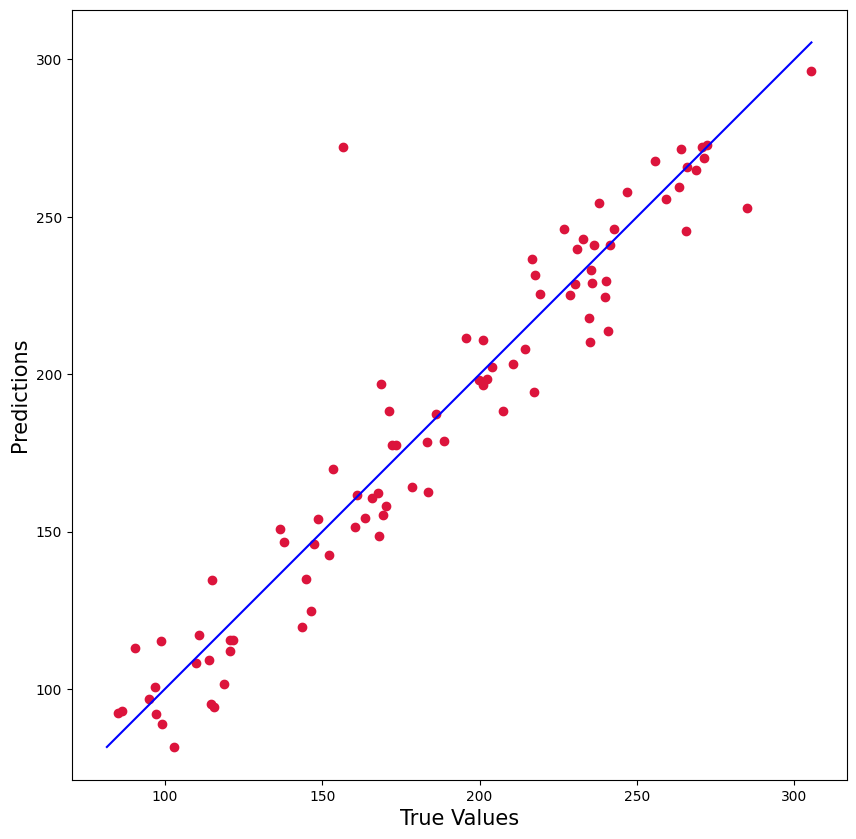

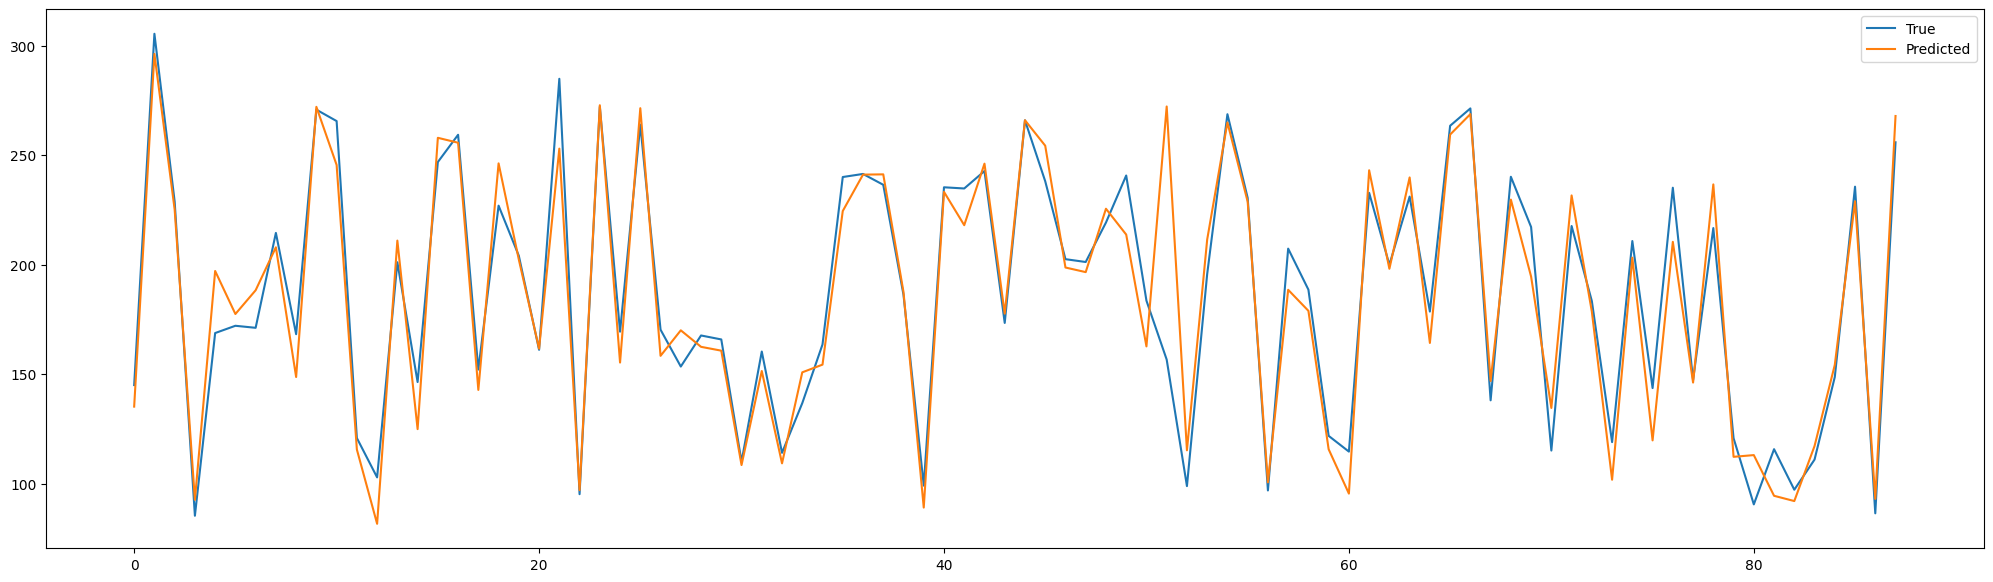

In [59]:
df = df_raw.copy()

df = df[['a_BAL_SEPA_A_HV_Neg_mA_PV', 
         'a_BAL_SEPA_A_HV_Pos_mA_PV', 
         'a_BAL_SEPA_AmbientTemp', 
         'a_BAL_SEPA_Belt_Gap', 
         'a_BAL_SEPA_Belt_Speed_PV', 
         'a_BAL_SEPA_E1_Torque_PV',
         'a_BAL_SEPA_E2_Torque_PV',
         'a_BAL_SEPA_Feed_PV',
         'a_BAL_SEPA_FeedRH',
         'a_BAL_SEPA_FeedTemp',
         'a_BAL_SEPA_M2_Speed_PV',
         'a_BAL_BOPA_Q_Mineral_Blower_Pressure',
         'a_BAL_BOPA_Q_Mineral_Pump_Current',
         'a_BAL_BOPA_Q_Carbon_Blower_Pressure',
         'a_BAL_BOPA_Q_Carbon_Pump_Current',
         'good_product']]

df = df[df['good_product'].notna()]
df = df[df['good_product'] != 0]

# profile = ProfileReport(df, title="Product EDA")
# profile.to_file(f"eda_product_stet.html")

y = df['good_product'].copy()
X = df.drop('good_product', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

# Use GridSearchCV to find the best number of components and other parameters for PLS regression
pls = PLSRegression()
param_grid = {'n_components': [i for i in range(1, 16)],
                'scale': [True, False],
                'max_iter': [i for i in range(100, 1000, 100)]}
grid = GridSearchCV(pls, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
grid.fit(X_train, y_train)

evaluate(grid, X_test, y_test)

# Predict Bad Product

Best model:  PLSRegression(max_iter=100, n_components=4)
Best R2 grid:  0.5014928788905175
Best R2 estimator:  0.5110069522434317
Best RMSE estimator:  1.162371524796367


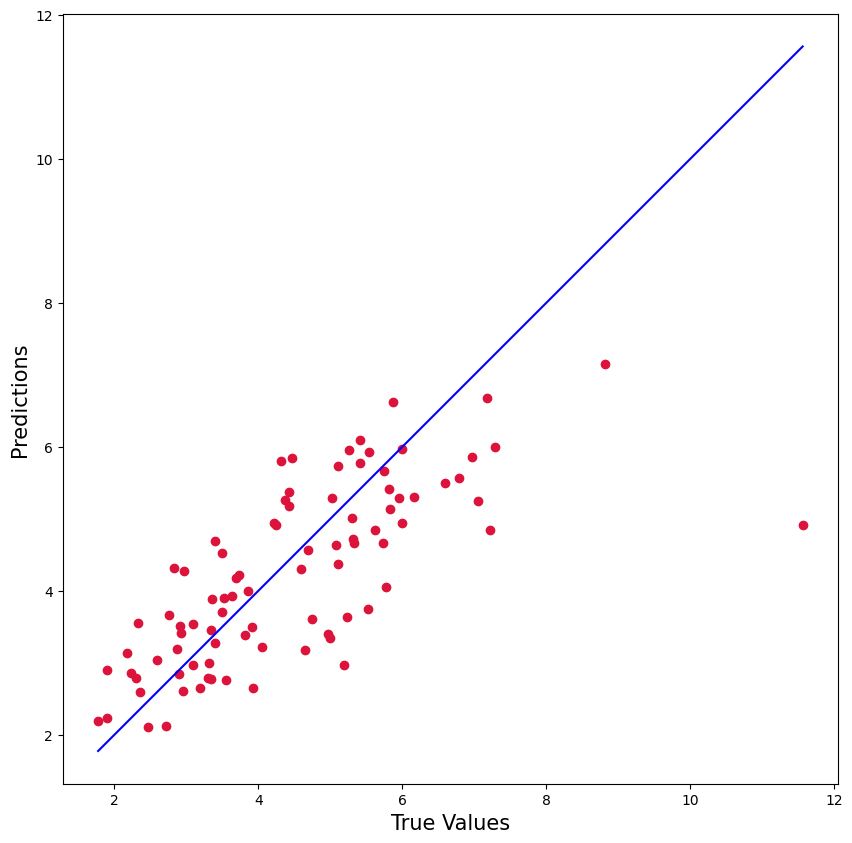

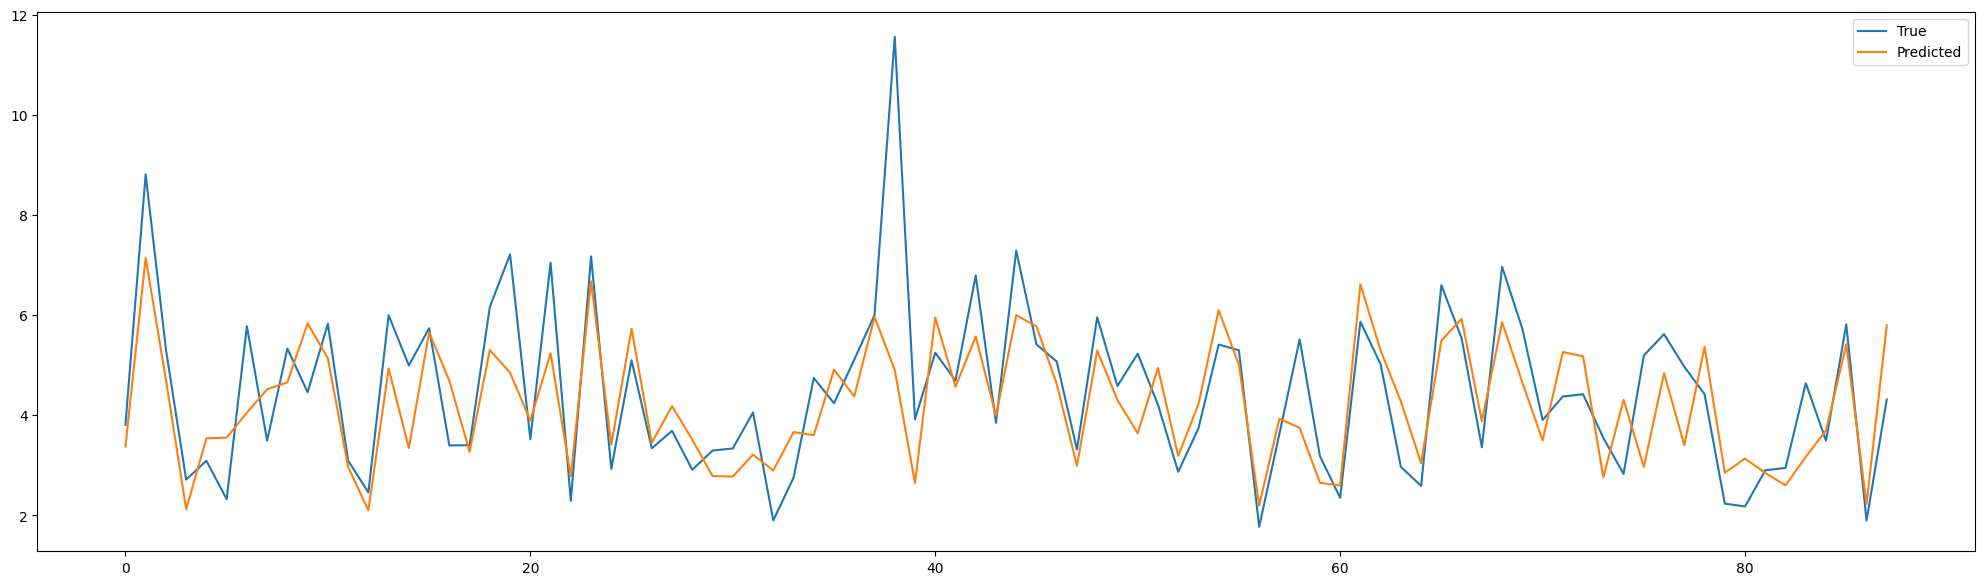

In [61]:
df = df_raw.copy()

df = df[['a_BAL_SEPA_A_HV_Neg_mA_PV', 
         'a_BAL_SEPA_A_HV_Pos_mA_PV', 
         'a_BAL_SEPA_AmbientTemp', 
         'a_BAL_SEPA_Belt_Gap', 
         'a_BAL_SEPA_Belt_Speed_PV', 
         'a_BAL_SEPA_E1_Torque_PV',
         'a_BAL_SEPA_E2_Torque_PV',
         'a_BAL_SEPA_Feed_PV',
         'a_BAL_SEPA_FeedRH',
         'a_BAL_SEPA_FeedTemp',
         'a_BAL_SEPA_M2_Speed_PV',
         'a_BAL_BOPA_Q_Mineral_Blower_Pressure',
         'a_BAL_BOPA_Q_Mineral_Pump_Current',
         'a_BAL_BOPA_Q_Carbon_Blower_Pressure',
         'a_BAL_BOPA_Q_Carbon_Pump_Current',
         'bad_product']]

df = df[df['bad_product'].notna()]
df = df[df['bad_product'] != 0]

# profile = ProfileReport(df, title="Product EDA")
# profile.to_file(f"eda_product_stet.html")

y = df['bad_product'].copy()
X = df.drop('bad_product', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

# Use GridSearchCV to find the best number of components and other parameters for PLS regression
pls = PLSRegression()
param_grid = {'n_components': [i for i in range(1, 16)],
                'scale': [True, False],
                'max_iter': [i for i in range(100, 1000, 100)]}
grid = GridSearchCV(pls, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
grid.fit(X_train, y_train)

evaluate(grid, X_test, y_test)

Best model:  PLSRegression(max_iter=100, n_components=8)
Best R2 grid:  0.46131194884799703
Best R2 estimator:  0.3391473571020348
Best RMSE estimator:  4.288396335625354


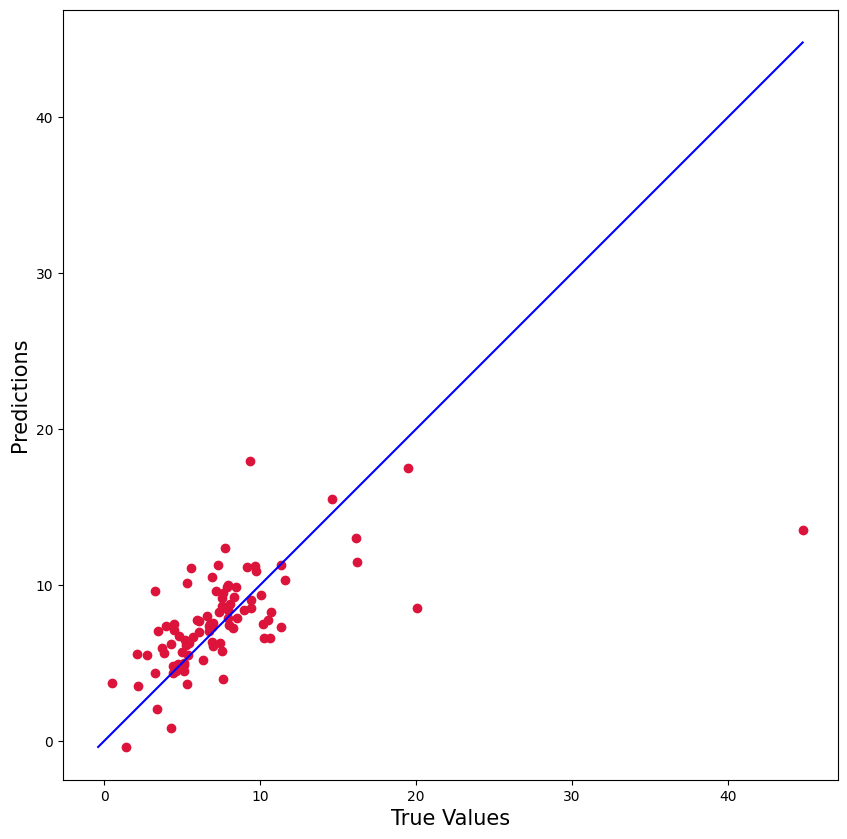

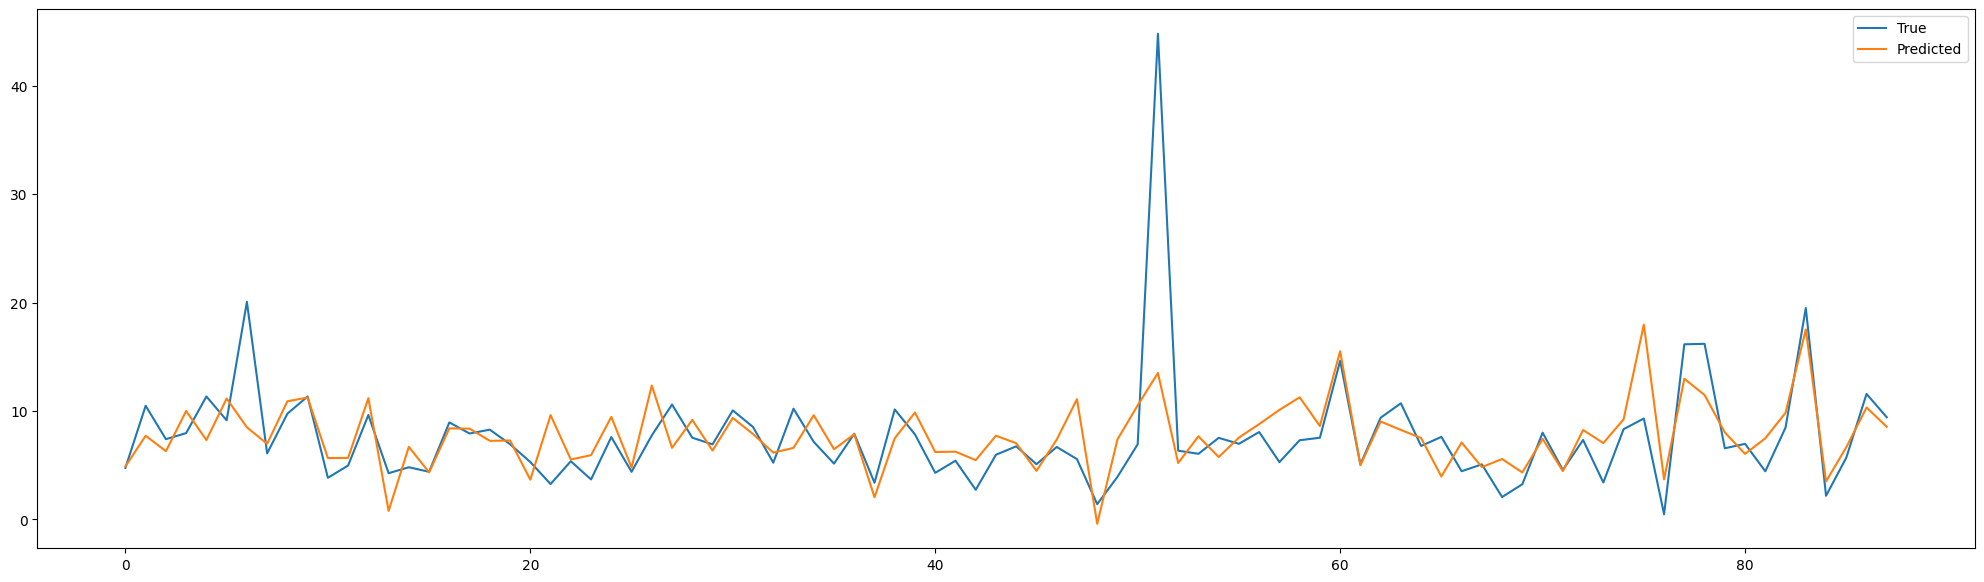

In [29]:
df = df_raw.copy()

df = df[['a_BAL_SEPA_A_HV_Neg_mA_PV', 
         'a_BAL_SEPA_A_HV_Pos_mA_PV', 
         'a_BAL_SEPA_AmbientTemp', 
         'a_BAL_SEPA_Belt_Gap', 
         'a_BAL_SEPA_Belt_Speed_PV', 
         'a_BAL_SEPA_E1_Torque_PV',
         'a_BAL_SEPA_E2_Torque_PV',
         'a_BAL_SEPA_Feed_PV',
         'a_BAL_SEPA_FeedRH',
         'a_BAL_SEPA_FeedTemp',
         'a_BAL_SEPA_M2_Speed_PV',
         'a_BAL_BOPA_Q_Mineral_Blower_Pressure',
         'a_BAL_BOPA_Q_Mineral_Pump_Current',
         'a_BAL_BOPA_Q_Carbon_Blower_Pressure',
         'a_BAL_BOPA_Q_Carbon_Pump_Current',
         'bad_carbon']]

df = df[df['bad_carbon'].notna()]
df = df[df['bad_carbon'] != 0]

# profile = ProfileReport(df, title="Product EDA")
# profile.to_file(f"eda_product_stet.html")

y = df['bad_carbon'].copy()
X = df.drop('bad_carbon', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

# Use GridSearchCV to find the best number of components and other parameters for PLS regression
pls = PLSRegression()
param_grid = {'n_components': [i for i in range(1, 16)],
                'scale': [True, False],
                'max_iter': [i for i in range(100, 1000, 100)]}
grid = GridSearchCV(pls, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
grid.fit(X_train, y_train)

evaluate(grid, X_test, y_test)

# Pipeline

Best model:  Pipeline(steps=[('boxcox',
                 BoxCoxTransformer(feature_names=['a_BAL_SEPA_A_HV_Neg_mA_PV',
                                                  'a_BAL_SEPA_A_HV_Pos_mA_PV'],
                                   lambda_=-0.3)),
                ('pls',
                 PLSRegression(max_iter=100, n_components=6, scale=False))])
Best R2 grid:  0.11487692799301294
Best R2 estimator:  0.11140985783938084
Best RMSE estimator:  0.006857045338104876


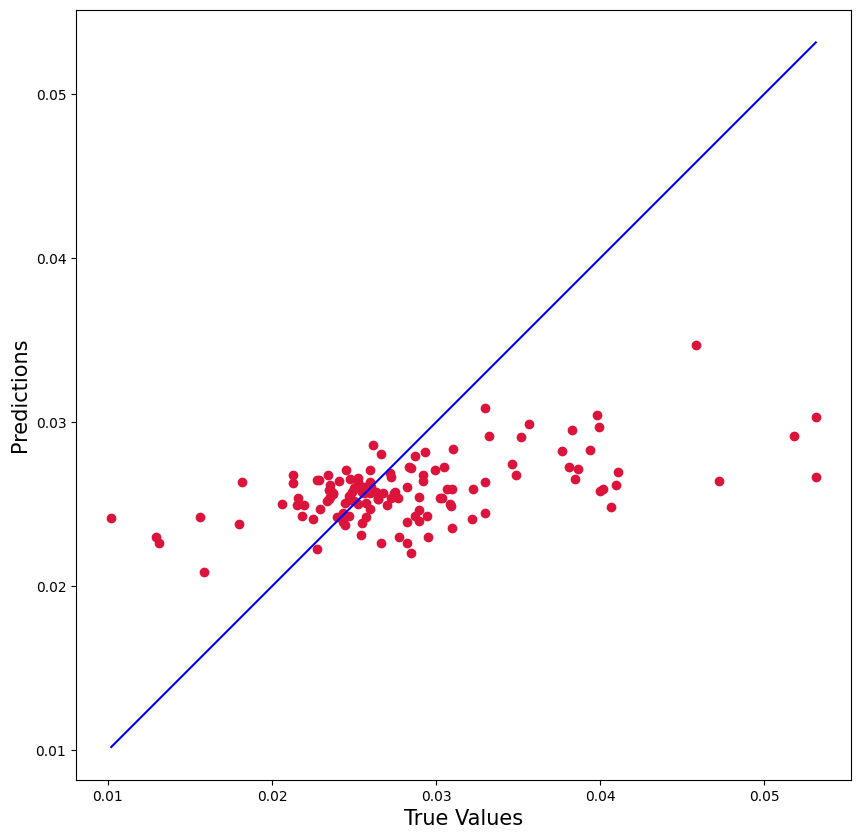

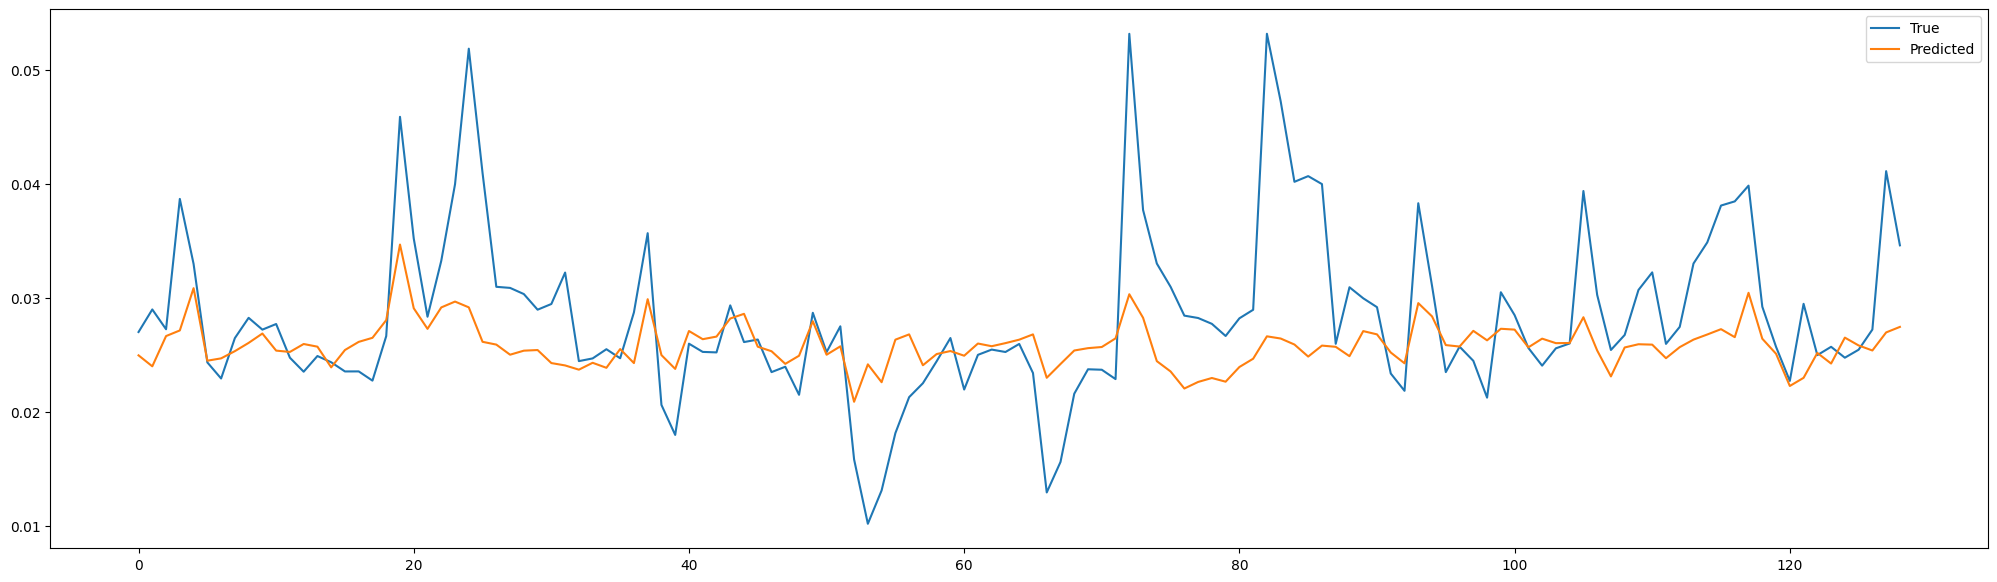

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin


df = df_raw.copy()

df = df[features + ['a_BAL_SEPA_Q_P_LOI']]

df = df[df['a_BAL_SEPA_Q_P_LOI'].notna()]
df = df[df['a_BAL_SEPA_Q_P_LOI'] != 0]

# Apply 3 sigma rule to a_BAL_SEPA_Q_P_LOI to remove outliers
df = df[np.abs(df['a_BAL_SEPA_Q_P_LOI'] - df['a_BAL_SEPA_Q_P_LOI'].mean()) <= (3 * df['a_BAL_SEPA_Q_P_LOI'].std())]

# Apply box cox transformation to skewed a_BAL_SEPA_A_HV_Neg_mA_PV and a_BAL_SEPA_A_HV_Pos_mA_PV
# df['a_BAL_SEPA_A_HV_Neg_mA_PV'], lambda_Neg = stats.boxcox(df['a_BAL_SEPA_A_HV_Neg_mA_PV'].to_numpy())
# df['a_BAL_SEPA_A_HV_Pos_mA_PV'], lambda_Pos = stats.boxcox(df['a_BAL_SEPA_A_HV_Pos_mA_PV'].to_numpy())

y = df.a_BAL_SEPA_Q_P_LOI.copy()
X = df.drop('a_BAL_SEPA_Q_P_LOI', axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
X_train = X[:int(0.8 * len(X))]
X_test = X[int(0.8 * len(X)):]
y_train = y[:int(0.8 * len(y))]
y_test = y[int(0.8 * len(y)):]


# Define an sklearn pipeline that will box-cox transform the a_BAL_SEPA_A_HV_Neg_mA_PV feature and a_BAL_SEPA_A_HV_Pos_mA_PV feature.
# Also, the pipline will transform features using SMA. The window size will be tuned using GridSearchCV.
# The pipeline will perform pls regression, random forest regression, and gradient boosting regression. The parameters for each model
# will be tuned using GridSearchCV. The best model will be selected based on the r2 score.
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names, lambda_=1):
        self.feature_names = feature_names
        self.lambda_ = lambda_

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        X['a_BAL_SEPA_A_HV_Pos_mA_PV'] = stats.boxcox(X['a_BAL_SEPA_A_HV_Pos_mA_PV'].to_numpy(), lmbda=self.lambda_)
        return X
    
# class SMATransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, feature_names, window_size):
#         self.feature_names = feature_names
#         self.window_size = window_size

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X_ = X.copy()
#         for feature_name in self.feature_names:
#             X_[feature_name] = X_[feature_name].rolling(window=self.window_size).mean()
#         return X_

# Define pipeline
pipe = Pipeline([
    ('boxcox', BoxCoxTransformer(['a_BAL_SEPA_A_HV_Neg_mA_PV', 'a_BAL_SEPA_A_HV_Pos_mA_PV'])),
    # ('sma', SMATransformer(['a_BAL_SEPA_A_HV_Neg_mA_PV', 'a_BAL_SEPA_A_HV_Pos_mA_PV'], 1)),
    ('pls', PLSRegression()),
    # ('rf', RandomForestRegressor()),
    # ('gb', GradientBoostingRegressor())
])

# Define parameter grid
param_grid = {
    'pls__n_components': [i for i in range(1, X_train.shape[1])],
    'pls__scale': [True, False],
    'pls__max_iter': [i for i in range(100, 1000, 100)],
    'boxcox__lambda_': [i/10 for i in range(-10, 11, 1)],
    # 'rf__n_estimators': [i for i in range(100, 1000, 100)],
    # 'rf__max_depth': [i for i in range(1, 16)],
    # 'gb__n_estimators': [i for i in range(100, 1000, 100)],
    # 'gb__max_depth': [i for i in range(1, 16)]
}

# Define grid search
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

# Fit grid search
grid.fit(X_train, y_train)

# # Evaluate model
evaluate(grid, X_test, y_test)